In [1]:
#===============================================================================
# %%
# IMPORT PACKAGES
import os
from pandas import DataFrame
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
# import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
import contextily as ctx
from geodatasets import get_path

In [2]:
#===============================================================================
# %%
#* SET CWD TO REPO ROOT
print(f"CWD:{os.getcwd()}")
def trim_path_to_substring(path, substring):
    index = path.find(substring)
    if index == -1:
        raise ValueError(f"Substring '{substring}' not found in path: {path}")
    trimmed_path = path[:index + len(substring):]
    trimmed_path = trimmed_path.lstrip(os.sep)
    return trimmed_path

repo_name = 'PAJTK-PAD-proj'
os.chdir(trim_path_to_substring(os.getcwd(),repo_name))
print(f"CWD:{os.getcwd()}")


CWD:c:\Users\jaros\proj\src\source\PAJTK-PAD-proj\src
CWD:c:\Users\jaros\proj\src\source\PAJTK-PAD-proj


In [3]:
#===============================================================================
# %%
#* READ DATA
file= os.path.join('data','credit-data.csv')
fraud_data: DataFrame = pd.read_csv(file)
fraud_data: DataFrame = shuffle(fraud_data)
fraud_data_loaded = fraud_data.copy()


In [4]:
#===============================================================================
# %%
#* RELOAD DATA
fraud_data = fraud_data_loaded.copy()
df = fraud_data.copy()


In [5]:
#===============================================================================
# %%
#* amount bins
def add_amt_bin(df):
    amt_bins=[0, 200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000, 5000, 10000, 23000]
    bins = amt_bins
    bin_labels = [f"{bins[i]}-{bins[i+1]}" for i in range(len(bins)-1)]
    df['amt_bin'] = pd.cut(df['amt'], bins=bins, labels=bin_labels, right=False)

add_amt_bin(df)


In [6]:
#===============================================================================
# %%
#* time periods
def categorize_time_period(timestamp):
    hour = timestamp.hour
    if 5 <= hour < 12:
        return 'morning'
    elif 12 <= hour < 16:
        return 'afternoon'  # change from noon to afternoon
    elif 16 <= hour < 20:
        return 'evening'
    else:
        return 'night'
df['trans_date_trans_time_dt'] = pd.to_datetime(arg=df['trans_date_trans_time'], format='%d/%m/%Y %H:%M')
df['time_period'] = df['trans_date_trans_time_dt'].apply(categorize_time_period)
df['day_of_week'] = df['trans_date_trans_time_dt'].dt.day_name()


In [7]:
#===============================================================================
# %%
#* calculate distances
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Radius of the Earth in kilometers
    
    # Convert latitude and longitude from degrees to radians
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    
    # Calculate differences
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    
    # Haversine formula
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    
    # Calculate distance
    distance = R * c
    return distance
df['cust_merch_distance'] = haversine(df['lat'], df['long'], df['merch_lat'], df['merch_long'])



In [8]:
#===============================================================================
# %%
#* number of transactions per customer
df['num_of_transactions'] = df.groupby('cc_num').cumcount() + 1



In [9]:
#===============================================================================
# %%
#* client age at transaction time

# Convert 'dob' column to datetime and extract year
dob_year = pd.to_datetime(df['dob'], format='%d/%m/%Y').dt.year

# Convert 'trans_date_trans_time' column to datetime and extract year
trans_year = pd.to_datetime(df['trans_date_trans_time_dt']).dt.year

# Calculate age of the customer
df['age_of_user'] = trans_year - dob_year


In [10]:
#===============================================================================
# %%
#* DROP COLUMNS

# Usuwamy kolumny z unikatowymi identyfikatorami
df.drop('Unnamed: 0', axis=1, inplace=True)
df.drop('trans_num', axis=1, inplace=True)

# Imie i nazwisko jest nam nie potrzebne bo mamy cc_num
df.drop('first', axis=1, inplace=True)
df.drop('last', axis=1, inplace=True)

# dane juz nie potrzebne, bo przekształcone 
df.drop(columns=['trans_date_trans_time', 'trans_date_trans_time_dt', 'dob', 'cc_num', 'lat', 'long', 'merch_lat', 'merch_long'], inplace=True)

# te dane są kategoryczne o zbyt duze licznie unikalnych wartości aby ich uzyc - moze da się jakoś je przetworzyć?
df.drop(columns=['merchant', 'city', 'job', 'street'], inplace=True)

df.drop(columns=['zip', 'unix_time'], inplace=True)


<Axes: >

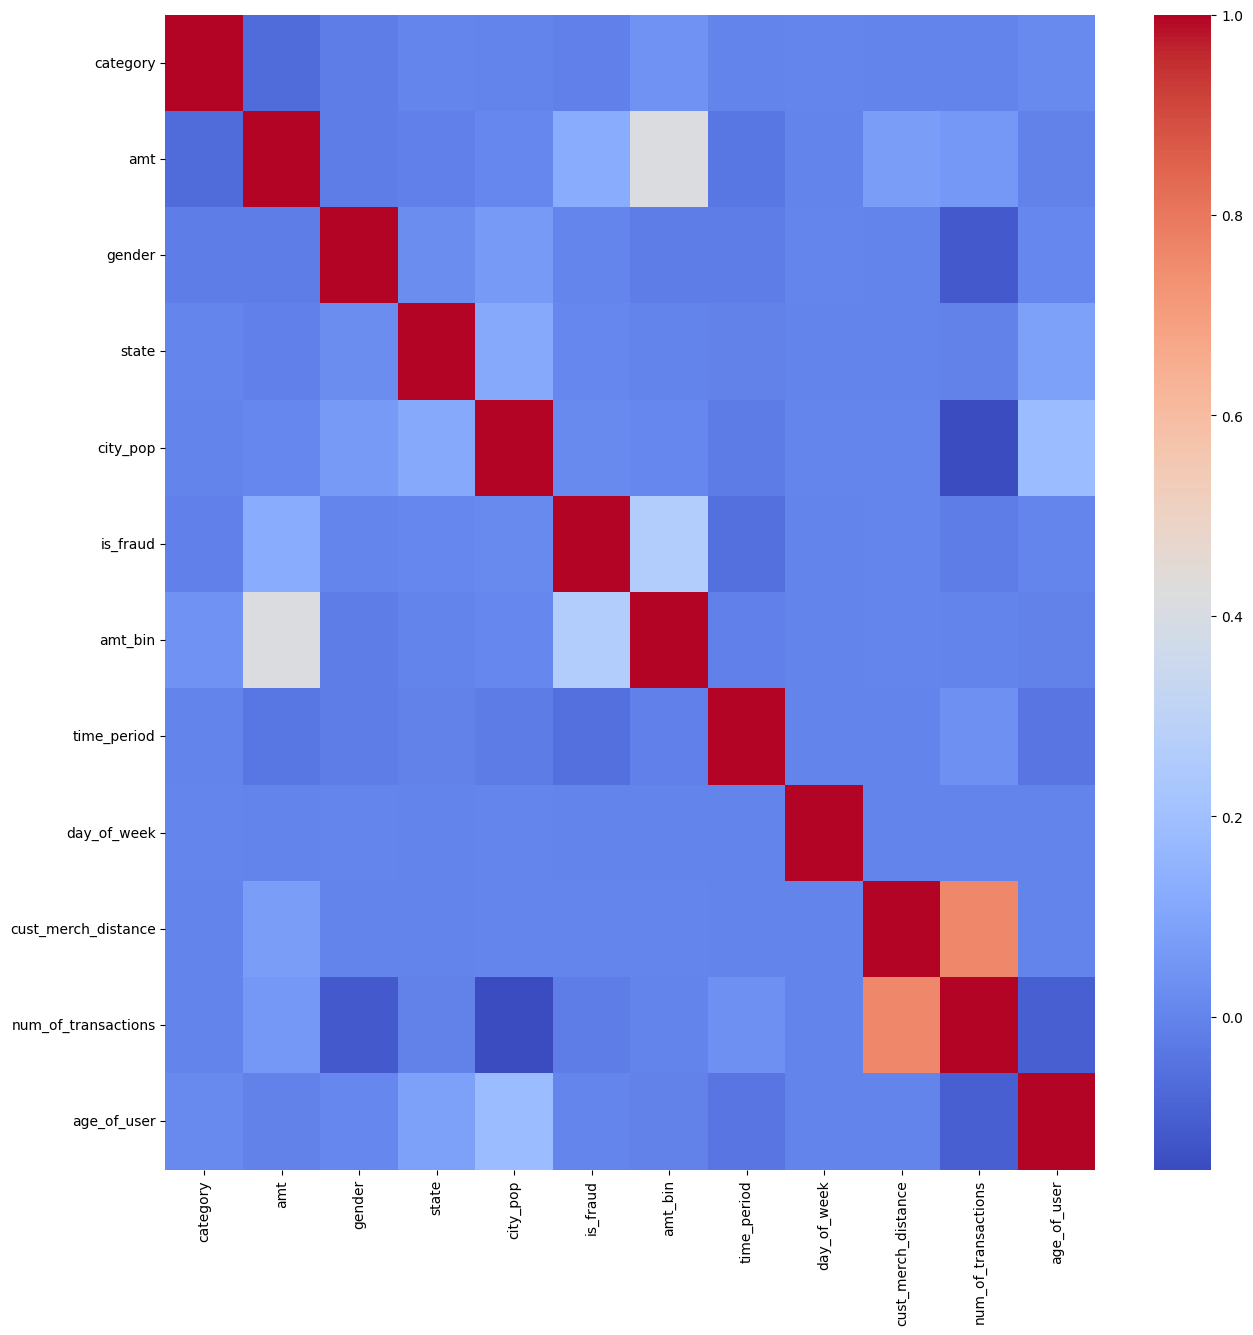

In [11]:
#===============================================================================
# %%
#* CORRELATION MATRIX
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(15, 15))
corr = df[lambda df:[c for c in df.columns]].apply(lambda x : pd.factorize(x)[0]).corr()
sns.heatmap(corr.loc[lambda df:[c for c in df.columns],lambda df:[c for c in df.columns]],cmap='coolwarm')


In [12]:
#===============================================================================
# %%
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.utils import shuffle
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier 
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix



In [13]:
#===============================================================================
# %%
#* SPLIT FEATURES AND TARGET (independent and dependent variables)
Y = df[['is_fraud']]
X = df.drop(columns=['is_fraud'])


In [14]:
#===============================================================================
# %%
#* cechy o typach nie numerycznych
# cat_columns = ['category', 'gender', 'state', 'time_period', 'day_of_week']
cat_columns = X.select_dtypes(exclude=["bool_","number"]).columns.values.tolist()
print(f"categorical columns:")
print(cat_columns)



categorical columns:
['category', 'gender', 'state', 'amt_bin', 'time_period', 'day_of_week']


In [15]:
#===============================================================================
# %%
#* CATEGORICAL UNIQUE VALUES
# Dictionary to store number of unique values for each column
num_unique_values = {}

# Calculate number of unique values for each column in the DataFrame
for col in df.columns:
    if col in cat_columns:
        num_unique_values[col] = df[col].nunique()

# Display the number of unique values for each categorical column
for col, num_unique in num_unique_values.items():
    print(f"Number of unique values in column '{col}': {num_unique}")



Number of unique values in column 'category': 14
Number of unique values in column 'gender': 2
Number of unique values in column 'state': 50
Number of unique values in column 'amt_bin': 13
Number of unique values in column 'time_period': 4
Number of unique values in column 'day_of_week': 7


In [16]:
#===============================================================================
# %%
#* REPLACE categorical columns with One Hot Encoded
cat_transformer_X = make_column_transformer(
    (OneHotEncoder(sparse_output=False), cat_columns),
    sparse_threshold= 0,
    verbose_feature_names_out=False,
    remainder='drop')

ohe_df = pd.DataFrame(cat_transformer_X.fit_transform(X), columns=cat_transformer_X.get_feature_names_out())
X = pd.concat([X.reset_index(drop=True), ohe_df.reset_index(drop=True)], axis=1).drop(cat_columns, axis=1)
print(X.shape)
print(X)




(555719, 95)
           amt  city_pop  cust_merch_distance  num_of_transactions  \
0        33.44    641349            24.001059                    1   
1        41.51      5778            59.609002                    1   
2        34.23     51427            68.530967                    1   
3         3.21       606             7.925826                    1   
4         3.38      4090            95.238599                    1   
...        ...       ...                  ...                  ...   
555714  117.56      2661           110.786497                  650   
555715   73.58       140            57.235662                  872   
555716   13.69       571            95.513640                  673   
555717   86.24       970            67.961407                  882   
555718   51.29      1196            52.176096                  840   

        age_of_user  category_entertainment  category_food_dining  \
0                44                     0.0                   0.0   
1       

In [17]:
#===============================================================================
# %%
#* FIND NUMERIC CATEGORICAL
# szukamy również danych o charakterze kategorycznym zapisanych w kolumnach numerycznych poprzez wyszukanie kolumn o małych zbiorach wartości unikalnych
print(f"\nunique values in columns:")
for col in X.select_dtypes(include=["number"]).columns:
    c_uniq = len(X[col].unique())
    if  c_uniq > 2:
        print(f'{col}: {c_uniq}')





unique values in columns:
amt: 37256
city_pop: 835
cust_merch_distance: 555719
num_of_transactions: 2144
age_of_user: 81


In [18]:
#===============================================================================
# %%
#* SPLIT DATA INTO train and test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state = 5, stratify=Y['is_fraud'])



In [19]:
#===============================================================================
# %%
#* IDENTIFY QUANT COLUMNS
print(f"categorical columns:")
print(cat_columns)

quant_columns = [ c for c in X_train.columns if c not in cat_columns and c not in cat_transformer_X.get_feature_names_out()]

print(f"\nquant_columns:")
print(quant_columns)


categorical columns:
['category', 'gender', 'state', 'amt_bin', 'time_period', 'day_of_week']

quant_columns:
['amt', 'city_pop', 'cust_merch_distance', 'num_of_transactions', 'age_of_user']


In [20]:
#===============================================================================
# %%
#* NORMALIZE/SCALE QUANT COLUMNS
std_scaler = StandardScaler()

X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[quant_columns] = std_scaler.fit_transform(X_train[quant_columns])
X_test_scaled[quant_columns] = std_scaler.transform(X_test[quant_columns])

X_train_scaled.describe()


,amt,city_pop,cust_merch_distance,num_of_transactions,age_of_user,category_entertainment,category_food_dining,category_gas_transport,category_grocery_net,category_grocery_pos,...,time_period_evening,time_period_morning,time_period_night,day_of_week_Friday,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday
count,4.445750e+05,4.445750e+05,4.445750e+05,4.445750e+05,4.445750e+05,444575.000000,444575.000000,444575.000000,444575.000000,444575.000000,...,444575.000000,444575.000000,444575.000000,444575.000000,444575.000000,444575.000000,444575.000000,444575.000000,444575.000000,444575.000000
mean,1.327508e-16,3.064648e-17,3.658478e-16,7.233687e-17,-9.718968e-17,0.072253,0.070506,0.101438,0.035166,0.094205,...,0.202740,0.227057,0.368026,0.112845,0.207025,0.112042,0.167684,0.106864,0.198293,0.095248
std,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,0.258907,0.255997,0.301909,0.184200,0.292113,...,0.402041,0.418930,0.482269,0.316403,0.405174,0.315418,0.373586,0.308940,0.398714,0.293558
min,-4.263864e-01,-2.935134e-01,-2.609922e+00,-1.318987e+00,-1.816813e+00,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-3.725400e-01,-2.911346e-01,-7.145442e-01,-8.064350e-01,-7.832983e-01,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,-1.379992e-01,-2.856116e-01,7.095699e-02,-2.018868e-01,-9.428841e-02,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,8.493619e-02,-2.283705e-01,7.693712e-01,6.162247e-01,6.521390e-01,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.416278e+02,9.336711e+00,2.496859e+00,5.722029e+00,2.834004e+00,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [21]:
#===============================================================================
# %%
#* SAMPLING / REBALANCING
# to address class imbalance -> fraud cases are rare so could ignore or overtrain
# i.e. reduce bias
# SMOTE (Synthetic Minority Over-sampling Technique)
from imblearn.over_sampling import SMOTE
smote = SMOTE(sampling_strategy = 'auto') # balance to make fraud and not-fraud equal

n = 1000 # rebalance to how many per class
X_train.reset_index(drop=True, inplace=True)
Y_train.reset_index(drop=True, inplace=True)

Y_sampled = Y_train.groupby('is_fraud', group_keys=False).apply(lambda x: x.sample(min(len(x), n), replace=False))
X_sampled = X_train.loc[Y_sampled.index]

X_resampled, Y_resampled = smote.fit_resample(X_sampled, Y_sampled['is_fraud'])

print("\nshape:")
print(X_resampled.shape)

print("\nresampled dataset:")
print(X_resampled)



shape:
(2000, 95)

resampled dataset:
         amt  city_pop  cust_merch_distance  num_of_transactions  age_of_user  \
0      49.04      8874            94.235365                  321           20   
1      53.92      1645            54.295752                  356           44   
2      70.28      9521            89.370198                   90           43   
3      52.01    238602            33.788728                  572           27   
4     108.45     59744            80.305586                  553           36   
...      ...       ...                  ...                  ...          ...   
1995  291.00      3766            33.172529                  118           36   
1996  723.23      7728            96.102842                   10           61   
1997  836.44      1804            65.081809                  226           46   
1998  769.50      3119            98.256455                  407           78   
1999  887.62      2274            26.589400                   92      

C:\Users\jaros\AppData\Local\Temp\ipykernel_26356\293980256.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  Y_sampled = Y_train.groupby('is_fraud', group_keys=False).apply(lambda x: x.sample(min(len(x), n), replace=False))


In [22]:
#===============================================================================
# %%
#* TRAIN MODEL

# Gradient Boosting - handles imbalanced, good for fraud type of data
# Hyperparameter Tuning - optimize and try avoiding over/under fitting
# ROC-AUC - measures how well fraud and non-fraud cases are separated; accuracy can be misleading

# chain steps into a pipeline
pipeline = Pipeline([
    ('clf', GradientBoostingClassifier())
])

# hyperparameter grid
param_grid = {
    'clf__n_estimators': [50, 100, 150, 200],   # number of trees (Boosting rounds)
    'clf__learning_rate': [0.01, 0.1, 0.2],     # step size to control contribution of each tree
    'clf__max_depth': [3, 4, 5, 6]              # maximum depth of each tree (controls model complexity); impacts overfitting
}
# hyperparameter tuning - find best combination
grid_search = GridSearchCV(
    pipeline, 
    param_grid, 
    cv=10,                  # 10-fold cross-validation (split data into 10 parts, train on 9 and test on 1)
    scoring='roc_auc',      # evaluate based on ROC-AUC (important for fraud detection)
    n_jobs=-1               # use all cpu cores
)

grid_search.fit(X_resampled, Y_resampled)


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('clf', GradientBoostingClassifier())]),
             n_jobs=-1,
             param_grid={'clf__learning_rate': [0.01, 0.1, 0.2],
                         'clf__max_depth': [3, 4, 5, 6],
                         'clf__n_estimators': [50, 100, 150, 200]},
             scoring='roc_auc')

In [23]:
#===============================================================================
# %%
#* BEST MODEL
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Score:", grid_search.best_score_)
model_gradient_boosting = grid_search.best_estimator_
#** CONCLUSION:
# The model flags too many trx as fraud :)
# Could be useful for flagging but not for automated blocking.


Best Parameters: {'clf__learning_rate': 0.2, 'clf__max_depth': 5, 'clf__n_estimators': 200}
Best Cross-Validation Score: 0.9906500000000001


In [24]:
#===============================================================================
# %%
#* TEST MODEL - PREDICT

def test_model(model, name):
    Y_pred = model.predict(X_test)
    Y_pred_proba = model.predict_proba(X_test)  # Returns probability for each class
    model_test_results = {
        'Y_test': Y_test,
        'Y_pred': Y_pred,
        'Y_pred_proba': Y_pred_proba,
        'name': name
    }
    return model_test_results



In [25]:
#===============================================================================
# %%
#* MODEL STATS

def model_stats(Y_test, Y_pred, Y_pred_proba, name):
    
    print(f"\n{'='*20}")
    print(f"\n{'='*2} MODEL NAME: {name}")
    print(f"\n{'='*20}")
    
    
    #* MODEL STATS - confusion matrix
    import matplotlib.pyplot as plt

    # Normalize the confusion matrix
    conf_matrix = confusion_matrix(Y_test, Y_pred)
    conf_matrix_norm = conf_matrix / conf_matrix.sum(axis=1)[:, np.newaxis]  # normalize along the true axis

    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix_norm, annot=True, fmt=".2%", cmap="Blues", cbar=False)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix (Normalized)')
    plt.show()

    #* MODEL STATS - scalar metrics
    from sklearn.metrics import precision_score, recall_score, f1_score
    from sklearn.metrics import roc_auc_score

    precision = precision_score(Y_test, Y_pred)
    recall = recall_score(Y_test, Y_pred)
    f1 = f1_score(Y_test, Y_pred)
    roc_auc = roc_auc_score(Y_test, Y_pred_proba[:, 1])  # Use predicted 

    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")
    print(f"ROC-AUC Score: {roc_auc:.4f}")
    print(
    """
    # Precision: How many of the predicted fraud cases are actually fraud? Low Precision means many false positives.
    # Recall: How many of the actual fraud cases did we detect? High means most frauds were detected(few false negatives).
    # F1-score: A balanced metric that combines Precision and Recall. High means the model can distinguish fraud vs. non-fraud well.
    """   
    )

    #* MODEL STATS - classification report
    from sklearn.metrics import classification_report
    print(classification_report(Y_test, Y_pred))

    from sklearn.metrics import precision_recall_curve
    precision, recall, _ = precision_recall_curve(Y_test, Y_pred_proba[:, 1])

    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, marker='.', label="Precision-Recall Curve")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.legend()
    plt.grid()
    plt.show()




== MODEL NAME: Gradient Boosting



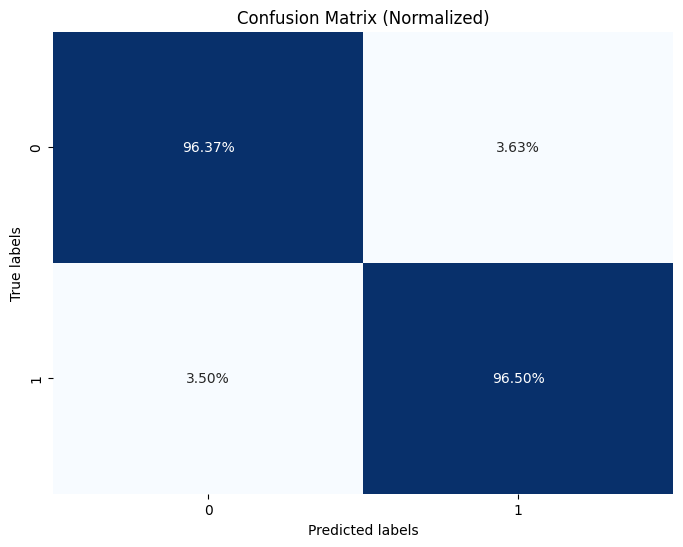

Precision: 0.0934
Recall: 0.9650
F1-score: 0.1703
ROC-AUC Score: 0.9923

    # Precision: How many of the predicted fraud cases are actually fraud? Low Precision means many false positives.
    # Recall: How many of the actual fraud cases did we detect? High means most frauds were detected(few false negatives).
    # F1-score: A balanced metric that combines Precision and Recall. High means the model can distinguish fraud vs. non-fraud well.
    
              precision    recall  f1-score   support

           0       1.00      0.96      0.98    110715
           1       0.09      0.97      0.17       429

    accuracy                           0.96    111144
   macro avg       0.55      0.96      0.58    111144
weighted avg       1.00      0.96      0.98    111144



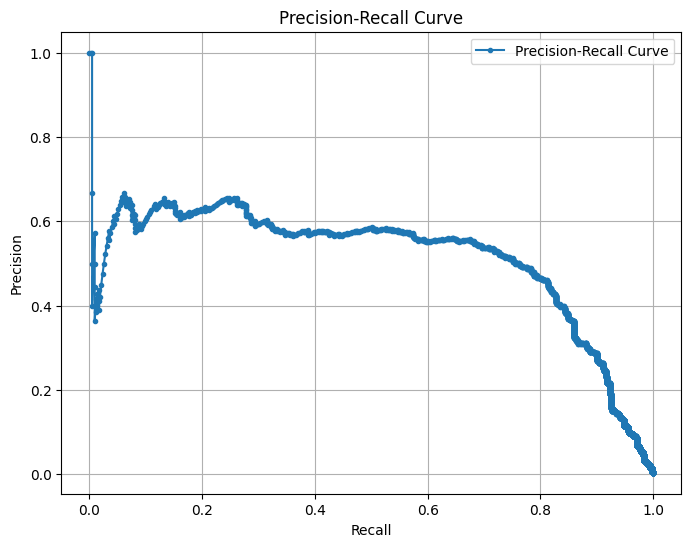

In [26]:
#===============================================================================
# %%
# TEST AND SHOW STATS
model_stats(**test_model(model_gradient_boosting, name = "Gradient Boosting"))


Widzimy, że model ma wysoki Recall, zatem z dużą skutecznością dokonuje predykcji jako fraud dla przypadków, które rzeczywiście są fraudami.
Niestety ma jednocześnie bardzo niski Precision, co oznacza, że wiele z przypadków, które oznaczył jako fraudy fraudami nie jest.
Model mocno "przestrzeliwuje".
Nie nadaje się do użycia w automatyzacjach, ale może nadałby się jako prymitywny sygnalizator, że transakcja potencjalnie może być fraudem.

W celu poprawy modelu można próbować modyfikacji z zakresu inżynierii cech, zmiany w skalowaniu, resamplingu, spróbować innych klasyfikatorów jak np. XGBoost.

Próbowałem używać klasyfikatora XGBoost. Początkowo działał, a potem zaczął rzucać błędem w Jupyter notebook i nie mogę dojść do tego dlaczego tak się stało. Wciąż można go uruchomić z poziomu konsoli w pliku .py. Jego wyniki były nieco bardziej zrównoważone, miał wyższy Precision, ale niższy Recall.